# Interstitial Growth Example
Shows how to implement late growth of oblique dendrites as side branches. In a region of the initially unbranched apical dendrite fronts remain active so that they can make a side branch at a later time. When a side branch is made the front and its immediate neighbors become inactive to prevent additional side branches from growing nearby.

<IPython.core.display.Javascript object>


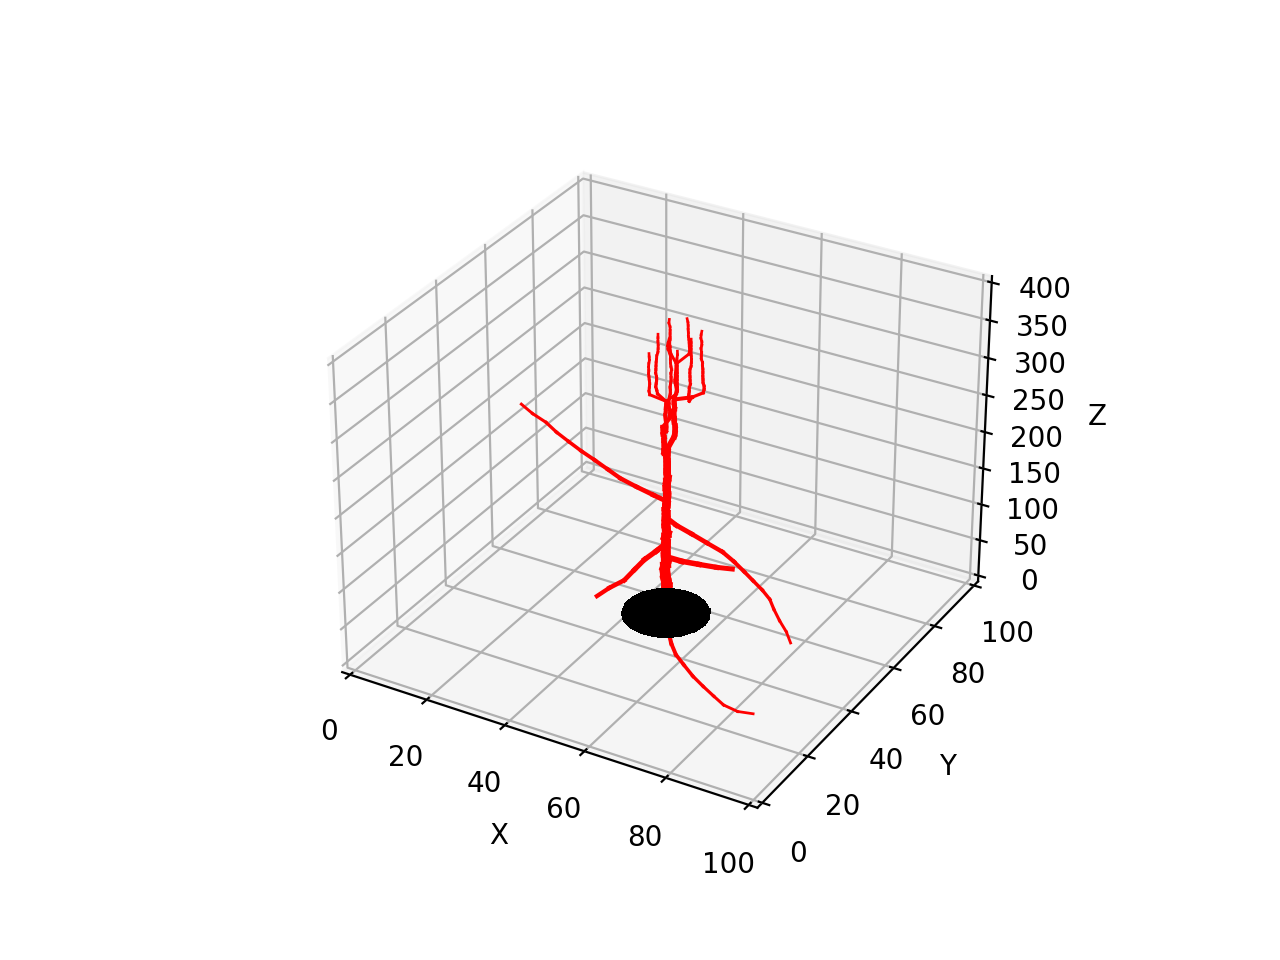

In [1]:
%matplotlib notebook

from neurodevsim.simulator import *

pia = 396 # z location of the pia
dir_to_pia = Point(0.,0.,4.) # length 4 vector towards pia

class InterstitialFront(Front):

    # defined layers to make the switches
    def manage_front(self,constellation):
        if self.swc_type == 1: # the soma
            # first segment of apical dendrite, grow out of soma
            new_pos = self.orig + Point(0.0,0.0,14.0)
            # this should always work -> no try/except code
            new_front = self.add_child(constellation,new_pos,radius=2.,swc_type=4) # make a new front and store it
            self.disable(constellation) # soma becomes inactive
        elif self.swc_type == 4: # apical dendrite: can sprout obliques later
            if self.end.z > pia:  # reached pia without tufted dendrite, terminate growth
                self.disable(constellation)
                return
            if self.num_children == 0: # initial extension of apical dendrite
                # check whether we should branch into tufted dendrite
                tufted = (self.path_length >= 220) and (np.random.random() < 0.4) # store decision
                count = 0 # counts number of add_child trials
                while count < 10: # try multiple times if needed
                    if tufted: # make tufted dendrite
                        rad = self.taper(0.8) # taper radius a lot
                        num_dendr = 0
                        rnd_dirs = self.unit_branching_sample(5) # generate more points than needed
                        for p in rnd_dirs: # make 2 branches
                            new_pos = self.end + dir_to_pia + p * 4.
                            # check for possible collisions
                            try:
                                new_front = self.add_child(constellation,new_pos,radius=rad,swc_type=9) # make a new front and store it
                                num_dendr += 1
                                if num_dendr == 2: # enough dendrites made
                                    # make front inactive: stops growing -> will not call this method again
                                    self.disable(constellation)
                                    return # done for this cycle
                            except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                                count += 1
                                continue # pick another new_pos, no attempt to correct the error
                        # did not branch
                        if self.num_children > 0: # single child made -> make front inactive
                            self.disable(constellation)
                            return
                    else: # extend apical dendrite
                        rad = self.taper(0.99)
                        rnd_dir = self.unit_heading_sample(width=15)
                        new_pos = self.end + dir_to_pia + rnd_dir * 0.5
                        try:
                            new_front = self.add_child(constellation,new_pos,radius=rad) # make a new front and store it
                            if (self.path_length < 50.): # close to soma, only extension
                                self.disable(constellation) # no interstitial growth
                            return # done for this cycle
                        except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                            count += 1
                            continue # pick another new_pos, no attempt to correct the error
            else: # check for interstitial growth of apical dendrite
                if np.random.random() < 0.0025: # make oblique dendrite
                    rad = self.taper(0.6) # taper radius a lot
                    count = 0 # counts number of add_child trials
                    while count < 10: # try multiple times if needed
                        rnd_dir = self.unit_heading_sample(mean=90,width=10) # close to perpendicular
                        new_pos = self.end + rnd_dir * 4.0
                        try:
                            new_front = self.add_child(constellation,new_pos,radius=rad,swc_type=8) # make a new front and store it
                            self.disable(constellation) # stop interstitial growth
                             # stop interstitial branching within 10 µm distance
                            neighbors = self.get_neighbors(constellation,10.,branch_stop=True)
                            for front in neighbors:
                                if front.is_active():
                                    front.disable(constellation) # stop interstitial growth
                            return # done for this cycle
                        except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                            count += 1
                            continue # pick another new_pos, no attempt to correct the error
                    # did not grow
                    self.disable(constellation) # stop trying

        elif self.swc_type == 8: # oblique dendrite: not influenced by pia
            if self.path_length > 250: # stop growing
                self.disable(constellation)
                return 
            rad = self.taper(0.95) # taper radius
            count = 0 # counts number of add_child trials
            while count < 10: # try multiple times if needed
                rnd_dir = self.unit_heading_sample(width=10)
                new_pos = self.end + rnd_dir * 5.0
                #print (self,new_pos,rad)
                try:
                    new_front = self.add_child(constellation,new_pos,radius=rad) # make a new front and store it
                    # make front inactive: stops growing -> will not call this method again
                    self.disable(constellation)
                    return # done for this cycle
                except (CollisionError, GridCompetitionError, InsideParentError, VolumeError) as error:
                    #print (constellation.cycle,self._fid,error)
                    count += 1
                    continue # pick another new_pos, no attempt to correct the error
            # did not grow
            self.disable(constellation) # stop trying
        else: # tufted dendrite, attracted by pia
            if self.end.z > pia:  # reached pia, terminate growth
                self.disable(constellation)
                return
            branch = (self.order < 4) and (np.random.random() < 0.1) # store decision
            count = 0 # counts number of add_child trials
            while count < 10: # try multiple times if needed
                if branch: # make tufted dendrite
                    rad = self.taper(0.8) # taper radius a lot
                    num_dendr = 0
                    rnd_dirs = self.unit_branching_sample(5) # generate more points than needed
                    for p in rnd_dirs: # make 2 branches
                        new_pos = self.end + dir_to_pia + p * 4.0
                        # check for possible collisions
                        try:
                            new_front = self.add_child(constellation,new_pos,radius=rad) # make a new front and store it
                            num_dendr += 1
                            if num_dendr == 2: # enough dendrites made
                                # make front inactive: stops growing -> will not call this method again
                                self.disable(constellation)
                                return # done for this cycle
                        except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                            count += 1
                            continue # pick another new_pos, no attempt to correct the error
                    # did not branch
                    if self.num_children > 0: # single child made -> make front inactive
                        self.disable(constellation)
                        return
                else: # extend tufted dendrite
                    rad = self.taper(0.99)
                    rnd_dir = self.unit_heading_sample(width=15)
                    new_pos = self.end + dir_to_pia + rnd_dir * 0.5
                    try:
                        new_front = self.add_child(constellation,new_pos,radius=rad) # make a new front and store it
                        self.disable(constellation) # no interstitial growth
                        return # done for this cycle
                    except (CollisionError, GridCompetitionError, InsideParentError, VolumeError) as error:
                        count += 1
                        continue # pick another new_pos, no attempt to correct the error
            

if __name__ == '__main__':

    fname = "output/interstitial.db"
    sim_volume = [[0., 0., 0.], [100.0,100.0,400.0]]
    neuron_types = [InterstitialFront]
    admin = Admin_agent(4,fname,sim_volume,neuron_types,verbose=0,plot=True)
    
    admin.add_neurons(InterstitialFront,"interstitial",1,[[50,50,10],[50,50,10]],10.)

    admin.simulation_loop(80)

    admin.destruction()